In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix
import random

In [113]:


class Node3D:
    def __init__(self, x, y, z, parent=None):
        self.x = x
        self.y = y
        self.z = z
        
    def distance(self, other):
        if isinstance(other, Node3D):
            return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2 + (self.z - other.z)**2)
        else:
            return np.inf

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y and self.z == other.z
    
    


class Graph3D:
    def __init__(self, max_x, max_y, max_z, point_distance=0.5):
        self.max_x = max_x
        self.max_y = max_y
        self.max_z = max_z
        
        # define the distance between neighboring points
        self.dx = point_distance
        self.dy = point_distance
        self.dz = point_distance
        
        self.x_size = int(np.ceil(max_x / self.dx))
        self.y_size = int(np.ceil(max_y / self.dy))
        self.z_size = int(np.ceil(max_z / self.dz))
        
        # self.nodes is a 3 dimensional list of all possible nodes
        self.nodes = np.empty((self.x_size, self.y_size, self.z_size), dtype=Node3D)
                
        # create a list of all possible nodes
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    self.nodes[x][y][z] = Node3D(x*self.dx, y*self.dy, z*self.dz)
                    
        self.obstacles = []
                    
    
    def random_node(self, prob=0.5):
        # randomly delete some nodes
        for x in range(self.nodes.shape[0]):
            for y in range(self.nodes.shape[1]):
                for z in range(self.nodes.shape[2]):
                    if random.random() < prob:
                        self.nodes[x][y][z] = None
        
        # remove nodes that are not connected to any other node
        for x in range(self.nodes.shape[0]):
            for y in range(self.nodes.shape[1]):
                for z in range(self.nodes.shape[2]):
                    if type(self.nodes[x][y][z]) is Node3D:
                        if len(self.get_neighbours(x, y, z)) == 0:
                            self.nodes[x][y][z] = None
                            
    def add_obstacle(self, x_min, y_min, z_min, x_max, y_max, z_max):
        self.obstacles.append([x_min, y_min, z_min, x_max, y_max, z_max])
        for x in range(self.nodes.shape[0]):
            for y in range(self.nodes.shape[1]):
                for z in range(self.nodes.shape[2]):
                    if x*self.dx >= x_min and x*self.dx <= x_max and y*self.dy >= y_min and y*self.dy <= y_max and z*self.dz >= z_min and z*self.dz <= z_max:
                        self.nodes[x][y][z] = None
    
    def get_neighbours(self, pos_x, pos_y, pos_z):
        neighbours = []
        potential_neighbours = [
            (pos_x + 1, pos_y, pos_z), (pos_x - 1, pos_y, pos_z),
            (pos_x, pos_y + 1, pos_z), (pos_x, pos_y - 1, pos_z),
            (pos_x, pos_y, pos_z + 1), (pos_x, pos_y, pos_z - 1),
            (pos_x + 1, pos_y + 1, pos_z), (pos_x + 1, pos_y - 1, pos_z),
            (pos_x + 1, pos_y, pos_z + 1), (pos_x + 1, pos_y, pos_z - 1),
            (pos_x - 1, pos_y + 1, pos_z), (pos_x - 1, pos_y - 1, pos_z),
            (pos_x - 1, pos_y, pos_z + 1), (pos_x - 1, pos_y, pos_z - 1),
            (pos_x, pos_y + 1, pos_z + 1), (pos_x, pos_y + 1, pos_z - 1),
            (pos_x, pos_y - 1, pos_z + 1), (pos_x, pos_y - 1, pos_z - 1),
            (pos_x + 1, pos_y + 1, pos_z + 1), (pos_x + 1, pos_y + 1, pos_z - 1),
            (pos_x + 1, pos_y - 1, pos_z + 1), (pos_x + 1, pos_y - 1, pos_z - 1),
            (pos_x - 1, pos_y + 1, pos_z + 1), (pos_x - 1, pos_y + 1, pos_z - 1),
            (pos_x - 1, pos_y - 1, pos_z + 1), (pos_x - 1, pos_y - 1, pos_z - 1)
        ]

        for nx, ny, nz in potential_neighbours:
            if 0 <= nx < self.x_size and 0 <= ny < self.y_size and 0 <= nz < self.z_size:
                neighbour = self.nodes[nx][ny][nz]
                if isinstance(neighbour, Node3D):
                    if not self.is_in_obstacle(neighbour.x, neighbour.y, neighbour.z):
                        if not any(self.is_intersection_3d(
                                self.nodes[pos_x][pos_y][pos_z].x, self.nodes[pos_x][pos_y][pos_z].y, self.nodes[pos_x][pos_y][pos_z].z,
                                neighbour.x, neighbour.y, neighbour.z,
                                obs[0], obs[1], obs[2], obs[3], obs[4], obs[5]) for obs in self.obstacles):
                            neighbours.append(neighbour)
        return neighbours

    def is_in_obstacle(self, x, y, z):
        for obs in self.obstacles:
            if obs[0] <= x <= obs[3] and obs[1] <= y <= obs[4] and obs[2] <= z <= obs[5]:
                return True
        return False

    def is_intersection_3d(self, x1, y1, z1, x2, y2, z2, xmin, ymin, zmin, xmax, ymax, zmax):
        def is_point_in_range(x, min_val, max_val):
            return min_val <= x <= max_val

        # Check intersection with each cube face

        # Left face (x = xmin)
        if x1 != x2:
            t1 = (xmin - x1) / (x2 - x1)
            y1_intersection = y1 + t1 * (y2 - y1)
            z1_intersection = z1 + t1 * (z2 - z1)
            if 0 <= t1 <= 1 and is_point_in_range(y1_intersection, ymin, ymax) and is_point_in_range(z1_intersection, zmin, zmax):
                return True

        # Right face (x = xmax)
        if x1 != x2:
            t2 = (xmax - x1) / (x2 - x1)
            y2_intersection = y1 + t2 * (y2 - y1)
            z2_intersection = z1 + t2 * (z2 - z1)
            if 0 <= t2 <= 1 and is_point_in_range(y2_intersection, ymin, ymax) and is_point_in_range(z2_intersection, zmin, zmax):
                return True

        # Front face (y = ymin)
        if y1 != y2:
            t3 = (ymin - y1) / (y2 - y1)
            x1_intersection = x1 + t3 * (x2 - x1)
            z1_intersection = z1 + t3 * (z2 - z1)
            if 0 <= t3 <= 1 and is_point_in_range(x1_intersection, xmin, xmax) and is_point_in_range(z1_intersection, zmin, zmax):
                return True

        # Back face (y = ymax)
        if y1 != y2:
            t4 = (ymax - y1) / (y2 - y1)
            x2_intersection = x1 + t4 * (x2 - x1)
            z2_intersection = z1 + t4 * (z2 - z1)
            if 0 <= t4 <= 1 and is_point_in_range(x2_intersection, xmin, xmax) and is_point_in_range(z2_intersection, zmin, zmax):
                return True

        # Bottom face (z = zmin)
        if z1 != z2:
            t5 = (zmin - z1) / (z2 - z1)
            x1_intersection = x1 + t5 * (x2 - x1)
            y1_intersection = y1 + t5 * (y2 - y1)
            if 0 <= t5 <= 1 and is_point_in_range(x1_intersection, xmin, xmax) and is_point_in_range(y1_intersection, ymin, ymax):
                return True

        # Top face (z = zmax)
        if z1 != z2:
            t6 = (zmax - z1) / (z2 - z1)
            x2_intersection = x1 + t6 * (x2 - x1)
            y2_intersection = y1 + t6 * (y2 - y1)
            if 0 <= t6 <= 1 and is_point_in_range(x2_intersection, xmin, xmax) and is_point_in_range(y2_intersection, ymin, ymax):
                return True

        return False

            
    def node_to_index(self, node):
        return int(node.x / self.dx) * self.y_size * self.z_size + int(node.y / self.dy) * self.z_size + int(node.z / self.dz)

    def index_to_node(self, index):
        x = (index // (self.y_size * self.z_size)) * self.dx
        y = ((index % (self.y_size * self.z_size)) // self.z_size) * self.dy
        z = (index % self.z_size) * self.dz
        return Node3D(x, y, z)
    
    def get_nearest_valid_node(self, node):
        min_distance = np.inf
        nearest_node = None
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    if isinstance(self.nodes[x][y][z], Node3D):
                        if not self.is_in_obstacle(self.nodes[x][y][z].x, self.nodes[x][y][z].y, self.nodes[x][y][z].z):
                            distance = self.nodes[x][y][z].distance(node)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_node = self.nodes[x][y][z]
        return nearest_node
      
    def compute_shortest_path(self, start, end):
        total_nodes = self.x_size * self.y_size * self.z_size
        graph = np.zeros((total_nodes, total_nodes))
        
        start = self.get_nearest_valid_node(start)
        end = self.get_nearest_valid_node(end)
        
        for x in range(self.x_size):
            for y in range(self.y_size):
                for z in range(self.z_size):
                    if isinstance(self.nodes[x][y][z], Node3D):
                        neighbours = self.get_neighbours(x, y, z)
                        for neighbour in neighbours:
                            start_index = self.node_to_index(self.nodes[x][y][z])
                            end_index = self.node_to_index(neighbour)
                            if not self.is_edge_intersecting_obstacle(self.nodes[x][y][z], neighbour):
                                distance = self.nodes[x][y][z].distance(neighbour)
                                graph[start_index, end_index] = distance

        graph_sparse = csr_matrix(graph)
        start_index = self.node_to_index(start)
        end_index = self.node_to_index(end)
        dist_matrix, predecessors = dijkstra(csgraph=graph_sparse, directed=False, return_predecessors=True, indices=start_index)
        
        path = []
        i = end_index
        while i != start_index:
            path.append(self.index_to_node(i))
            i = predecessors[i]
        path.append(start)
        return path[::-1]

    def is_edge_intersecting_obstacle(self, node1, node2):
        return any(self.is_intersection_3d(
            node1.x, node1.y, node1.z,
            node2.x, node2.y, node2.z,
            obs[0], obs[1], obs[2], obs[3], obs[4], obs[5]) for obs in self.obstacles)
    
    def path_length(self, path):
        length = 0
        for i in range(len(path)-1):
            length += path[i].distance(path[i+1])
        return length
        
    def plot_graph(self, path=None):
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # plot nodes
        node_color = 'blue'
        node_size = 5 
        node_alpha = 0.3  
        for x in range(self.nodes.shape[0]):
            for y in range(self.nodes.shape[1]):
                for z in range(self.nodes.shape[2]):
                    # is type of Node3D
                    # if type(self.nodes[x][y][z]) is Node3D:
                    if isinstance(self.nodes[x][y][z], Node3D):
                        ax.scatter(self.nodes[x][y][z].x, self.nodes[x][y][z].y, self.nodes[x][y][z].z, c=node_color, s=node_size, alpha=node_alpha)
                        
        # plot edges
        edge_color = 'black'
        linewidth = 0.8
        alpha = 0.3
        for x in range(self.nodes.shape[0]):
            for y in range(self.nodes.shape[1]):
                for z in range(self.nodes.shape[2]):
                    if isinstance(self.nodes[x][y][z], Node3D):
                        # neighbours = self.get_neighbours(x, y, z)
                        neighbours = self.get_neighbours(x, y, z)
                        for neighbour in neighbours:
                            ax.plot([self.nodes[x][y][z].x, neighbour.x], [self.nodes[x][y][z].y, neighbour.y], [self.nodes[x][y][z].z, neighbour.z], c=edge_color, linewidth=linewidth, alpha=alpha)
        
        # plot obstacles
        
        obstacle_color = 'purple'
        obstacle_alpha = 0.3
        for obstacle in self.obstacles:
            x_min, y_min, z_min, x_max, y_max, z_max = obstacle
            ax.bar3d(x_min, y_min, z_min, x_max - x_min, y_max - y_min, z_max - z_min, 
                     color=obstacle_color, alpha=obstacle_alpha)
            
        # plot path
        if path is not None:
            path_color = 'red'
            path_linewidth = 2
            path_alpha = 1.0
            for i in range(len(path)-1):
                start = path[i]
                end = path[i + 1]
                ax.quiver(start.x, start.y, start.z, end.x - start.x, end.y - start.y, end.z - start.z,
                          color=path_color, linewidth=path_linewidth, alpha=path_alpha)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
        



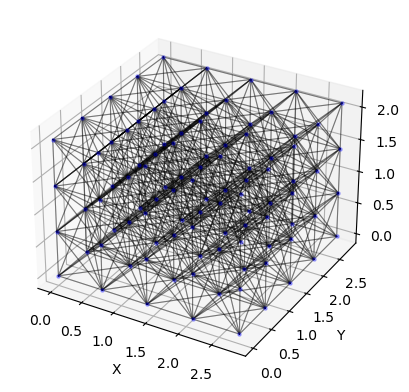

In [116]:
# create a 3D graph
max_x = 3.3
max_y = 3.3
max_z = 2.6

graph = Graph3D(max_x, max_y, max_z, point_distance=0.7)
graph.plot_graph()


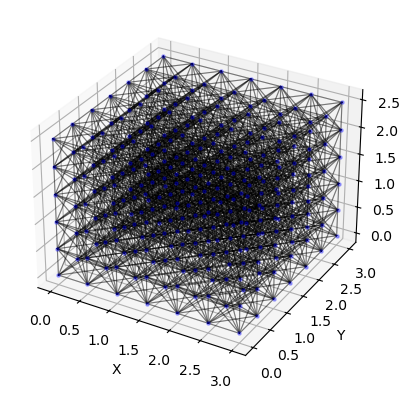

In [118]:
# adjust the point distance
max_x = 3.3
max_y = 3.3
max_z = 2.6

graph = Graph3D(max_x, max_y, max_z, point_distance=0.5)
graph.plot_graph()


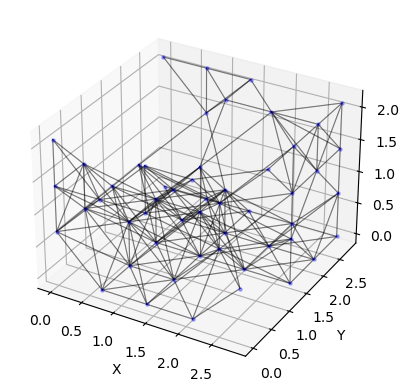

In [119]:
# remove some nodes
max_x = 3.3
max_y = 3.3
max_z = 2.6

graph = Graph3D(max_x, max_y, max_z, point_distance=0.7)
graph.random_node(prob=0.5)
graph.plot_graph()


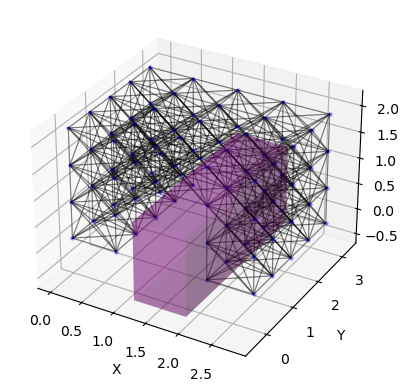

In [120]:
# add obstacles

max_x = 3.3
max_y = 3.3
max_z = 2.6

graph = Graph3D(max_x, max_y, max_z, point_distance=0.7)
graph.add_obstacle(1.2, -0.5, -0.5, 2, 3.3, 1)
graph.plot_graph()

Shortest path: [(0.0, 0.0, 0.0), (0.7, 0.7, 0.7), (1.4, 1.4, 1.4), (2.8, 2.8, 0.7), (2.8, 2.8, 0.0)]


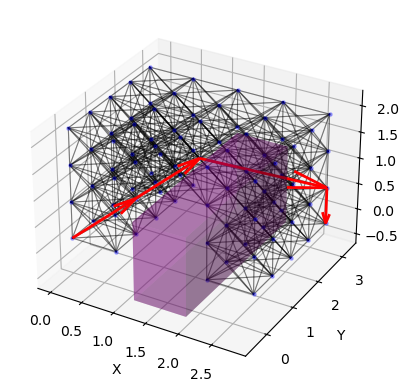

In [114]:
# find shortest path
max_x = 3.3
max_y = 3.3
max_z = 2.6

graph = Graph3D(max_x, max_y, max_z, point_distance=0.7)
# graph.random_node()
graph.add_obstacle(1.2, -0.5, -0.5, 2, 3.3, 1)

# print(graph.line_intersects_cube(0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 1.2, -0.5, -0.5, 2, 3.3, 1.5))

start_node = Node3D(0, 0, 0)
end_node = Node3D(3, 3, 0)
path = graph.compute_shortest_path(start_node, end_node)
print("Shortest path:", [(node.x, node.y, node.z) for node in path])

graph.plot_graph( path=path)


Shortest path: [(0.0, 0.0, 0.0), (0.0, 0.0, 0.7), (0.7, 0.0, 1.4), (1.4, 0.7, 1.4), (2.8, 0.7, 1.4), (2.8, 1.4, 0.7), (2.8, 2.8, 0.7)]


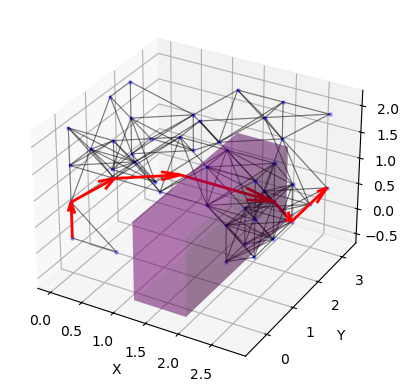

In [121]:

max_x = 3.3
max_y = 3.3
max_z = 2.6

graph = Graph3D(max_x, max_y, max_z, point_distance=0.7)
graph.random_node()
graph.add_obstacle(1.2, -0.5, -0.5, 2, 3.3, 1)


start_node = Node3D(0, 0, 0)
end_node = Node3D(3, 3, 0)
path = graph.compute_shortest_path(start_node, end_node)
print("Shortest path:", [(node.x, node.y, node.z) for node in path])

graph.plot_graph( path=path)
